In [1]:
import vk_api
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
from nltk.stem import SnowballStemmer
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model as lm
from sklearn.svm import SVR

In [2]:
group_id = 80512191
login, password = 'login', 'password'  # нужны логин и пароль
vk_session = vk_api.VkApi(login, password)

vk_session.auth()
    
tools = vk_api.VkTools(vk_session)

wall = tools.get_all('wall.get', 100, {'owner_id': -group_id})

print('Posts count:', wall['count'])


Posts count: 1562


In [3]:
wall.keys()

dict_keys(['count', 'items'])

In [4]:
n = wall['count']
n

1562

In [5]:
posts = wall['items']

In [8]:
posts[1]

{'attachments': [{'photo': {'access_key': '4f77dcf15093634a4a',
    'album_id': -7,
    'date': 1505037595,
    'height': 564,
    'id': 456239447,
    'owner_id': -80512191,
    'photo_1280': 'https://pp.userapi.com/c840238/v840238813/279e1/2HqwJA6DZmY.jpg',
    'photo_130': 'https://pp.userapi.com/c840238/v840238813/279de/_CGIPSNaRhI.jpg',
    'photo_604': 'https://pp.userapi.com/c840238/v840238813/279df/7sHchuGIaHk.jpg',
    'photo_75': 'https://pp.userapi.com/c840238/v840238813/279dd/O1ADxLRFsE8.jpg',
    'photo_807': 'https://pp.userapi.com/c840238/v840238813/279e0/hX4OpjE6JDY.jpg',
    'text': '',
    'user_id': 100,
    'width': 960},
   'type': 'photo'},
  {'poll': {'anonymous': 0,
    'answer_id': 0,
    'answers': [{'id': 919147418, 'rate': 17.4, 'text': '1', 'votes': 372},
     {'id': 919147419, 'rate': 21.8, 'text': '2', 'votes': 466},
     {'id': 919147420, 'rate': 14.5, 'text': '3', 'votes': 310},
     {'id': 919147421, 'rate': 5.14, 'text': '4', 'votes': 110},
     {'id'

In [9]:
# на вход подается поле 'text' одного поста, вычленяются описания и возвращается список из них 
def Divide(text):
    ans = []
    text = text.split('\n')
    
    for i in range(len(text)):
        if len(text[i])!=0 and text[i][0] in ['1','2','3','4','5']:
            t = text[i].split()
            t.pop(0)    # удаляем номер описания
            ans.append(' '.join(t))
    return ans


# на вход подается поле 'attachments' одного поста, вычленяются результаты голосвания и возаращается список из них
def ExtractPollRes(p):
    ans = []
    p = p['poll']['answers']
    if len(p) != 5:     # вероятно не то голосование
        return 0   
    for el in p:
        ans.append(el['rate'])
    return ans


# на вход подается один пост, возвращает True если присутствует голосование
def CheckForPoll(a):
    try:
        for i in range(len(a['attachments'])):
            if 'poll' in a['attachments'][i]:
                return True
        return False
    except:    # нет поля attachments и выдаст ошибку
        return False    

    
# на вход подается один пост, возвращаются 2 списка: описания и рещультаты     
def ParsePost(a):   
    try:
        descriptions = Divide(a['text'])   # делаем список из 5 описаний
    except:    # запись без текста
        return 0, 0
    
    # поиск голосования
    for i in range(len(a['attachments'])):
        if 'poll' in a['attachments'][i]:
            poll = a['attachments'][i]
            break
    
    poll_res = ExtractPollRes(poll)  # список из 5 результатов голосования
    
    return descriptions, poll_res
    
    
# принимает правильные ответы и предсказания, возвращает меру ошибки
def Cost(y,pred):
    error = 0
    for i in range(len(y)):
        error += (y[i]-pred[i])**2
    return error / 2 / float(len(y))


# принимает одно описание, возвращает описание без предлогов и с заменой слов на их основу
def stem_it_and_del_predlogi(descr):
    new_descr = []
    for word in descr.split():
        if word.lower() not in predlogi:
            new_descr.append(stemmer.stem(word))
    return ' '.join(new_descr)    
    

# принимает алгоритм регрессии, векторзайзер, считывает пост и пишет предсказанные места
def PostRes(clf,vec):
    post = input()
    p = []
    c = 1
    for i in range(len(post)):
        if post[i] == str(c) and post[i+1] == '.':
            descr = []
            c+=1
            for j in range(i+1,len(post)):
                if post[j] == 'h' and post[j+1] == 't':
                    break
                if post[j] == str(c) and post[j+1] == '.':
                    break
                if 'a' <= post[j] <= 'z' or 'A' <= post[j] <= 'Z' or '0' <= post[j] <= '9' \
                or 'а' <= post[j] <='я' or 'А' <= post[j] <= 'Я' or post[j] == ' ' or post[j] == 'ё':
                    descr.append(post[j])
            p.append(''.join(descr))
    
    for i in range(5):
        p[i] = stem_it_and_del_predlogi(p[i])
        
    p = vec.transform(p)
    
    pred = clf.predict(p.toarray())
    print(pred)
    for i in range(5):
        m = max(pred)
        for j in range(5):
            if pred[j] == m:
                print(i+1,' место:\t',j+1)
                pred[j] = -1
                break
    
    return


              
    

In [12]:
DATA = []
stemmer = SnowballStemmer('russian')
predlogi = ['без','для','до', 'из', 'от', 'у', 'к', 'в' , 'на', 'за', 'под', 'о' ]



for i in range(n):
    if CheckForPoll(posts[i]):     # если есть голосование
        descr, res = ParsePost(posts[i])    # список описаний и результатов
        if descr == 0 or res == 0:
            continue
        if len(descr) != len(res):
            continue
        for i in range(5):
            DATA.append([descr[i],res[i]])    # по одному описанию добавляем в DATA
            
for i in range(5):
    DATA.pop(0)
    
df = pd.DataFrame(DATA, columns = ['Description','Result'])  
df['Description'] = df['Description'].replace('[^a-zA-Z0-9а-яА-ЯёЁ]', ' ', regex = True)    # удаляем запятые, точки и т.д
df['Description'] = df['Description'].apply(stem_it_and_del_predlogi)    # удаляем предлоги и меняем слово на основу слова 
print(df.head())

# перемешиваем данные
new_order = np.random.permutation(len(df))
df = df.take(new_order)
print(df.head())
print(df.shape)


# разделяем даннные на тренировочные и тестовые для проверки качества на новых данных
X_train = list(df['Description'][600:])
y_train = list(df['Result'][600:])
X_test = list(df['Description'][:300])
y_test = list(df['Result'][:300])
X_cv = list(df['Description'][300:600])
y_cv = list(df['Result'][300:600])




                                         Description  Result
0  жительниц ира посл исламск революц вмест с сем...    5.20
1  длин и подробн стат том поч современ либеральн...   39.84
2  канадск военнослужа служ афганистан и как эт ч...    8.06
3  1999 год молод человек результат дтп попа ком ...   27.31
4  загадочн истор маленьк итальянск городк где по...   19.59
                                            Description  Result
1089  Vox пример американск двухпартийн систем объяс...   17.57
1867  документальн оскар ушел фильм про эдвард сноуд...   21.33
1797  длин и обстоятельн стат Vox том как американск...   23.94
1718  а вот обширн стат The New York Times том как ж...    9.70
1569  намет академическ конфликт очен важн всег чело...   42.53
(2205, 2)


In [13]:
vec = TfidfVectorizer(min_df = 15)
X_train = vec.fit_transform(X_train)
X_test = vec.transform(X_test)
X_cv = vec.transform(X_cv)

print(X_train.shape,X_test.shape,X_cv.shape)

names = vec.get_feature_names()

(1605, 440) (300, 440) (300, 440)


In [14]:
print(names)

['10', 'aeon', 'atlantic', 'bloomberg', 'club96047932', 'demon', 'googl', 'guardia', 'id1719186', 'id292146858', 'independent', 'laplac', 'magazin', 'nautilus', 'new', 'post', 'quartz', 'the', 'times', 'verg', 'vox', 'washington', 'wired', 'york', 'yorker', 'автор', 'актуальн', 'александр', 'америк', 'американск', 'аналитик', 'бол', 'больш', 'британск', 'будет', 'будут', 'будущ', 'бы', 'бывш', 'был', 'быт', 'важн', 'вам', 'вас', 'ваш', 'вед', 'век', 'весьм', 'вещ', 'взгляд', 'взял', 'вид', 'власт', 'вмест', 'внезапн', 'вниман', 'внутр', 'во', 'вод', 'воен', 'возможн', 'войн', 'вообщ', 'вопрос', 'вот', 'врем', 'врод', 'все', 'всег', 'всегд', 'всем', 'всех', 'вы', 'выбор', 'выгляд', 'выпуст', 'вышел', 'выясн', 'где', 'главн', 'говор', 'год', 'город', 'государств', 'да', 'даж', 'дал', 'дан', 'два', 'двух', 'действ', 'действительн', 'дел', 'дела', 'деньг', 'держ', 'дет', 'деятельн', 'довольн', 'долг', 'должн', 'дом', 'дональд', 'дорог', 'друг', 'дума', 'ег', 'ем', 'есл', 'ест', 'ещ', 'же',

In [15]:
error_train = []
error_cv = []

step = 30


for i in range(20,1355,step):
    reg = lm.Ridge()
    reg.fit(X_train[:i],y_train[:i])
    reg_pred_train = reg.predict(X_train[:i])
    reg_pred_cv = reg.predict(X_cv)
    error_train.append(Cost(y_train[:i],reg_pred_train))
    error_cv.append(Cost(y_cv,reg_pred_cv))

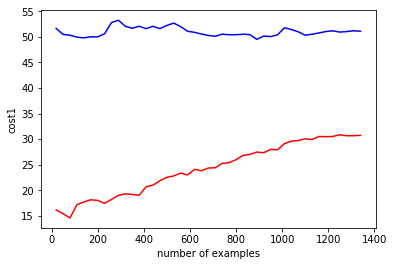

In [16]:
plt.plot(range(20,1355,step),error_train, color = 'r' )
plt.plot(range(20,1355,step),error_cv, color = 'b' )
plt.ylabel('cost1')
plt.xlabel('number of examples')
plt.show()


In [17]:
error_train = []
error_cv = []

step = 20


for i in range(10,1355,step):
    reg = KNeighborsRegressor(5)
    reg.fit(X_train[:i],y_train[:i])
    reg_pred_train = reg.predict(X_train[:i])
    reg_pred_cv = reg.predict(X_cv)
    error_train.append(Cost(y_train[:i],reg_pred_train))
    error_cv.append(Cost(y_cv,reg_pred_cv))

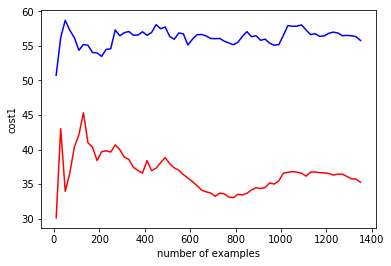

In [18]:
plt.plot(range(10,1355,step),error_train, color = 'r' )
plt.plot(range(10,1355,step),error_cv, color = 'b' )
plt.ylabel('cost1')
plt.xlabel('number of examples')
plt.show()

In [28]:
error_train = []
error_cv = []

step = 20

for i in range(10,1355,step):
    reg = SVR(kernel = 'linear', C = 10)
    reg.fit(X_train[:i],y_train[:i])
    reg_pred_train = reg.predict(X_train[:i])
    reg_pred_cv = reg.predict(X_cv)
    error_train.append(Cost(y_train[:i],reg_pred_train))
    error_cv.append(Cost(y_cv,reg_pred_cv))

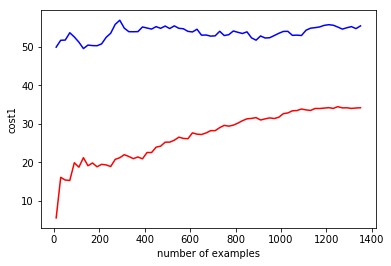

In [29]:
plt.plot(range(10,1355,step),error_train, color = 'r' )
plt.plot(range(10,1355,step),error_cv, color = 'b' )
plt.ylabel('cost1')
plt.xlabel('number of examples')
plt.show()

In [31]:
a = SVR(kernel = 'linear', C = 10)
a.fit(X_train,y_train)
p = a.predict(X_test)
for i in range(300):
    print(p[i], '\t',y_test[i])


24.8007862095 	 17.57
17.1846487624 	 21.33
14.8552330128 	 23.94
15.2928142968 	 9.7
18.0788413005 	 42.53
18.6845260815 	 18.79
16.1113211672 	 32.91
15.2849976034 	 24.53
20.7353068902 	 36.86
27.3211651393 	 38.59
19.8837993057 	 26.96
20.8595765631 	 16.55
25.1405775472 	 37.27
29.5237893323 	 17.95
10.9741108372 	 18.05
26.3268904813 	 11.92
11.4136395784 	 10.31
35.163275682 	 19.16
19.9096005571 	 7.67
20.6727622433 	 9.53
22.1140261537 	 14.59
11.5861850963 	 10.88
19.9413177223 	 25.47
23.5437389158 	 26.07
15.4298022749 	 11.91
20.1904466904 	 25.65
18.7367134497 	 8.85
10.6610454858 	 2.02
21.8964614197 	 34.38
11.1509186037 	 15.35
19.5106056554 	 34.99
8.45435655149 	 18.84
17.8434429545 	 24.56
24.910554716 	 22.81
24.692733802 	 4.26
25.8919077691 	 32.61
22.956884674 	 42.57
6.99339310563 	 9.34
10.7454765472 	 35.71
15.2559320859 	 38.3
19.7490411894 	 48.8
20.0725893056 	 20.83
17.2598364267 	 12.66
20.8114327901 	 30.97
8.06127790802 	 19.85
24.9184150253 	 22.15
18

In [32]:
PostRes(a,vec)

Update: переводим №1 и №5.  Подборка простых коротких статей быстрого приготовления.  1. Интервью с физиком, который в школе ненавидел биологию, а теперь возглавляет астробиологический отдел НАСА и пытается разгадать загадки эволюции с помощью теории плотной среды. Надеемся, что у нас в подписчиках есть школьные учителя, которые сделают из этого выводы.  https://goo.gl/8iog5G  2. Увлекательнейшая статья из разряда «неизвестное о привычном». Все мы играли в карты, но мало кто задумывался, откуда взялись эти трефы, бубны, тузы и валеты. Почему туз сильнее, чем король? Когда карты научились держать веером и почему это важно? В чем смысл «рубашек»? Прочитайте, узнаете много нового. Обе статьи прислал Андрей Лущаев.  https://goo.gl/QxfpNR  3. Статья о пользе научного метода при выработке политики в разных сферах, от образования до борьбы с преступностью. Как видно, многие государственные программы, коптящие небо своей бесполезностью, можно было бы забраковать на стадии разработки, если бы и

# Судя по графикам, в данном случае проблема high variance и нужно больше данных.